# CMA/ES MODIFIED. Sigma Base, 4th try: LL95, fixed cov, lapse + sigma_base

Same as 3Try, but now with LL95 to see it's effect.

Might be between LL and LL90?


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

## Reload data

In [3]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_ll95_4try_Mratiosigmaxsigmabaselinelapserate_repetitions3_170816
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-4c564044-8083-4f35-af32-b6fb4296447d.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_ll95_4try_Mratiosigmaxsigmabaselinelapserate_repetitions3_170816


In [4]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [5]:
parameter_names_sorted

['M', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [6]:
metric = 'dist_nll95'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])

In [7]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [8]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

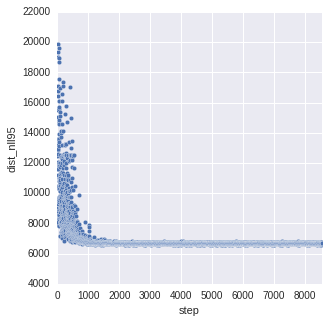

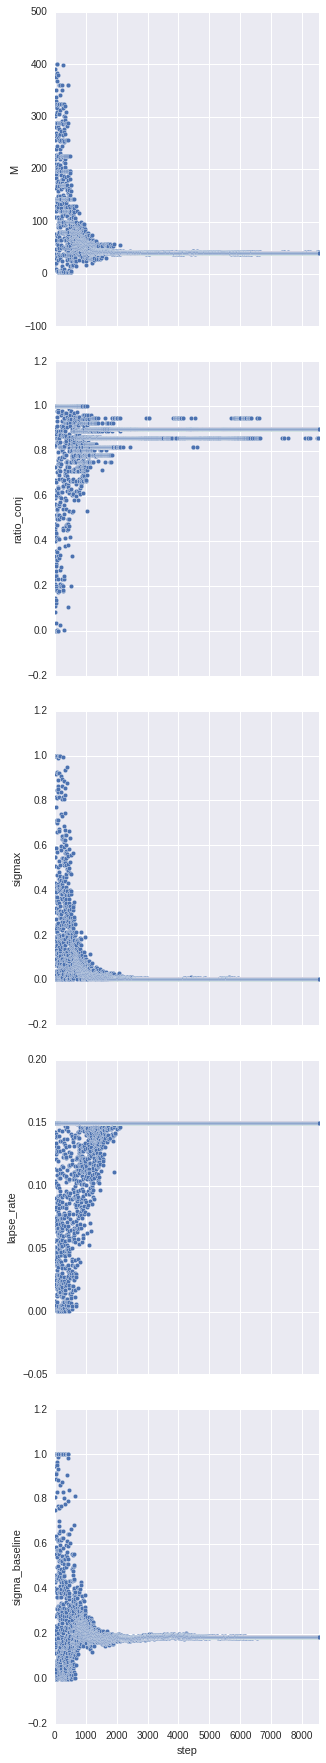

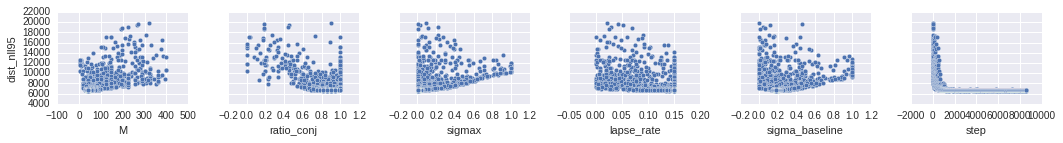

In [9]:
# Learning curve
g = sns.pairplot(df_best_fits,
             y_vars=[metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max())
     )


# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'sigma_baseline'],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))


# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'sigma_baseline', 'step'],
             y_vars=[metric],
            )



## Check parameters values obtained

In [10]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(100).median()
df_bestparams

step              8499.500000
dist_nll95        6692.729749
M                   40.000000
lapse_rate           0.150000
ratio_conj           0.900000
sigma_baseline       0.186751
sigmax               0.005000
dtype: float64

In [11]:
%run /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/experimentlauncher.py \
--action_to_do launcher_do_fitexperiment_allmetrics --inference_method none  --num_samples 200  --renormalize_sigma \
--autoset_parameters --code_type mixed  --sigmay 0.00001  --experiment_id bays09 \
--lapse_rate {df_bestparams['lapse_rate']} --M {int(df_bestparams['M'])} --sigmax {df_bestparams['sigmax']} \
--ratio_conj {df_bestparams['ratio_conj']} --sigma_baseline {df_bestparams['sigma_baseline']} \
--filter_datapoints_size 1500 --filter_datapoints_selection 'random'

Arguments: ['--action_to_do', 'launcher_do_fitexperiment_allmetrics', '--inference_method', 'none', '--num_samples', '200', '--renormalize_sigma', '--autoset_parameters', '--code_type', 'mixed', '--sigmay', '0.00001', '--experiment_id', 'bays09', '--lapse_rate', '0.15', '--M', '40', '--sigmax', '0.005', '--ratio_conj', '0.9', '--sigma_baseline', '0.186751096678', '--filter_datapoints_size', '1500', '--filter_datapoints_selection', 'random']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'action_to_do': 'launcher_do_fitexperiment_allmetrics', 'code_type': 'mixed', 'verbose': False, 'selection_num_sa

In [12]:
plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)

Doing Paper plots for bays09. 
Fig5 1, Fig6 1, Fig13 1


DATA T 1
DATA T 2
mu: 0.539, kappa: 0.054
{'R': 40.610651594187004, 'u': 1.2726180071955844, 'pvalue': 0.10157681277072006, 'V': 34.85207948141467}
DATA T 4
mu: 0.148, kappa: 0.095
{'R': 212.38974605931844, 'u': 4.4285158574149754, 'pvalue': 4.7441871873221686e-06, 'V': 210.06295145407188}
DATA T 6
mu: 0.025, kappa: 0.118
{'R': 441.95902376474845, 'u': 7.214894047356446, 'pvalue': 2.6989521728637555e-13, 'V': 441.82022410667554}


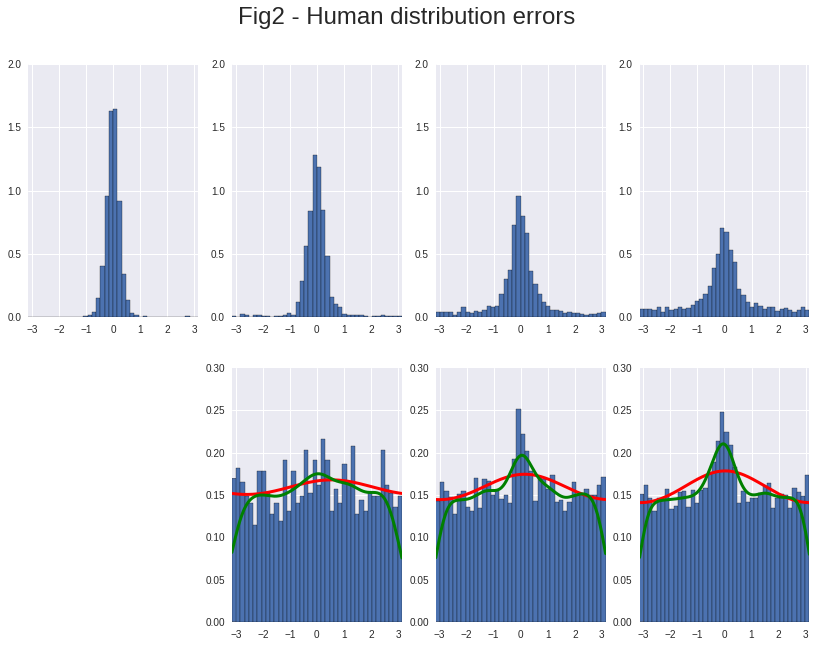

In [13]:
axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

MODEL T 1
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -872.19
Loglikelihood: -385.79
top 90% loglike: 174.46
MODEL T 2
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -1314.17
Loglikelihood: -1009.44
top 90% loglike: -454.18
mu: 0.166, kappa: 0.167
{'R': 124.62035289594093, 'u': 4.4877473508505927, 'pvalue': 3.599010896970789e-06, 'V': 122.90202282224604}
MODEL T 4
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -2102.25
Loglikelihood: -1503.16
top 90% loglike: -964.95
mu: 0.120, kappa: 0.162
{'R': 362.65235702095998, 'u': 7.5905380665200379, 'pvalue': 1.5876189252139739e-14, 'V': 360.05083434620997}
MODEL T 6
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -2455.44
Loglikelihood: -1759.33
top 90% loglike: -1241.43
mu: 0.115, kappa: 0.134
{'R': 503.10251464313581, 'u': 8.1614033268611141, 'pvalue': 1.1102230246251565e-16, 'V': 499.78184339657003}


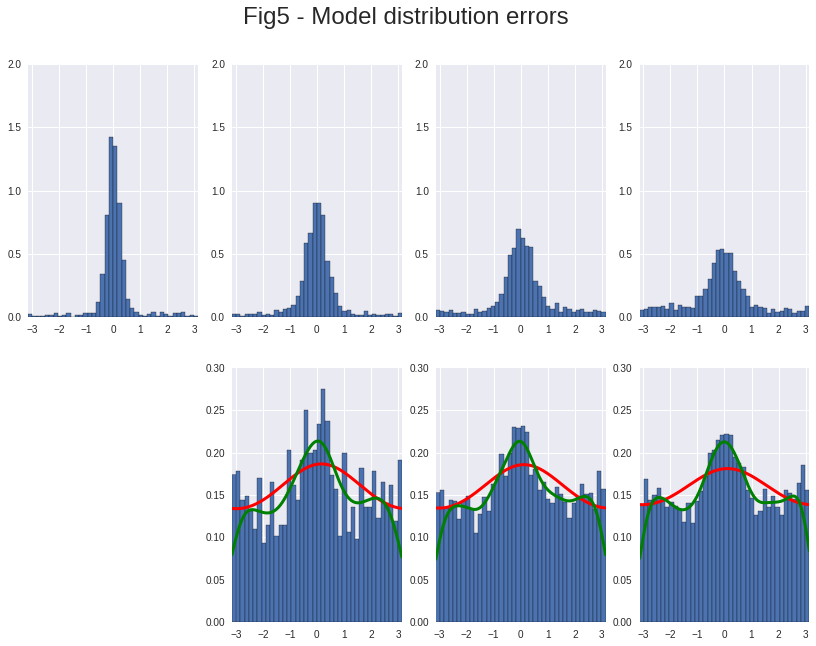

In [14]:
axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

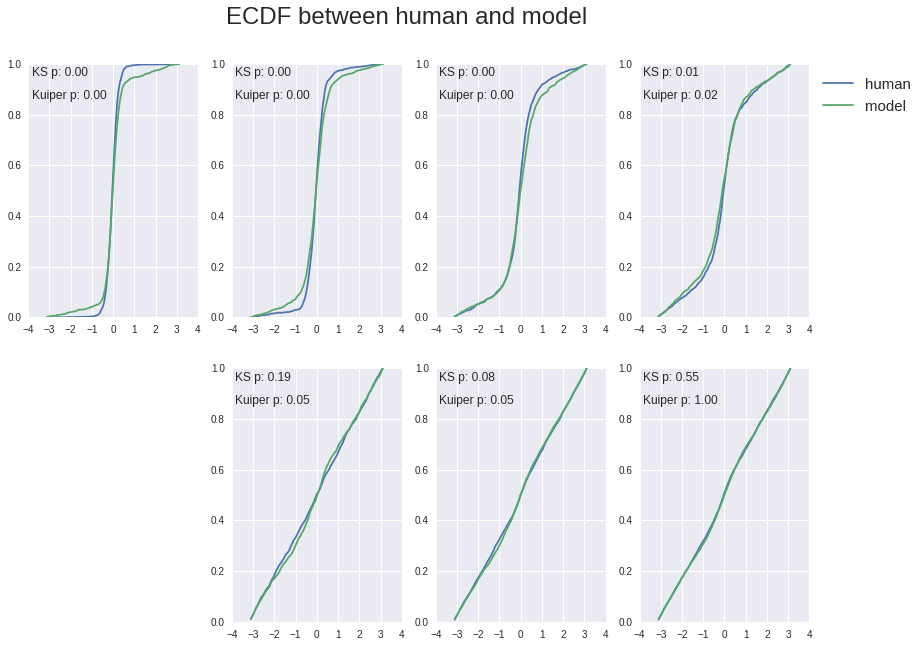

In [15]:
_ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)

0.00%, -- left - 18.08 20:55
Fit for T=1, 1/5
5.00%, 5s left - 18.08 20:55
Fit for T=1, 2/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -385.79
Loglikelihood: -346.81
top 90% loglike: 213.43
10.00%, 2m12s left - 18.08 20:57
Fit for T=1, 3/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -346.81
Loglikelihood: -347.68
top 90% loglike: 212.57
15.00%, 1m48s left - 18.08 20:57
Fit for T=1, 4/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -347.68
Loglikelihood: -368.35
top 90% loglike: 191.90
20.00%, 1m17s left - 18.08 20:56
Fit for T=1, 5/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -368.35
Loglikelihood: -531.42
top 90% loglike: 28.83
25.00%, 1m6s left - 18.08 20:56
Fit for T=2, 1/5
30.00%, 51s left - 18.08 20:56
Fit for T=2, 2/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -1009.44
Loglikelihood: -1019.72
top 90% loglike: -465.55
35.00%, 58s left - 18.08

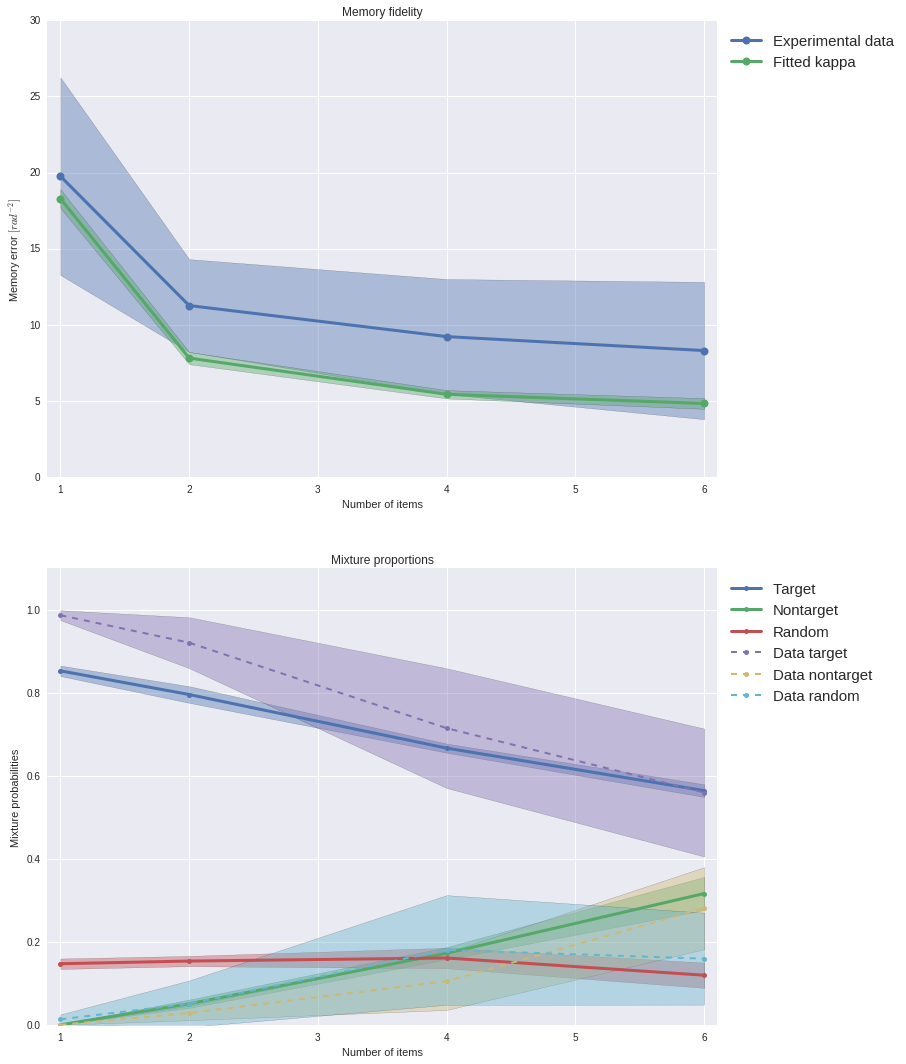

In [16]:
axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)

# ANALYSE ME: check if LL95 is good or not

unclear?